# Clustering Single-cell RNA sequencing data using Autoencoder and Kmeans

The lecture utilises single-cell RNA-seq data from "[scMAE: a masked autoencoder for single-cell RNA-seq clustering](https://doi.org/10.1093/bioinformatics/btae020)". The lecture is divided into the following categories:

1. Learn about raw single-cell data
2. Preprocessing raw data using [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html)
3. Methods
    - Autoencoder
    - KMeans
4. Train autoencoder model
5. Cluster low-dimensional representation

In [83]:
import numpy as np
import pandas as pd
import scanpy as sc
import h5py
import os
import argparse
import warnings
from IPython.core.display import Image, display
warnings.filterwarnings(action='ignore')

## Accessing single-cell data

- Melanoma dataset (Metastatic melanoma): Melanoma is a kind of skin cancer that starts in the melanocytes. Melanocytes are cells that make the pigment that gives skin its color. The pigment is called melanin.
- Download data from [Zenodo](https://zenodo.org/deposit/8175767)
- These are HDF5 stores containing single-cell gene expression datasets along with their cell types. > 4500 single cells isolated from 19 patients, profiling malignant, immune, stromal, and endothelial cells.
- Number of cells: 4513, number of genes: 23684, number of cell types: 9
- Dataset from [publication](https://www.weizmann.ac.il/mcb/tirosh/sites/mcb.tirosh/files/uploads/Tirosh_Dissecting_the_melanoma_ecosystem.pdf)
- Cell types: ['B cell', 'CD4+ T cell', 'Endothelial cell', "NK cell", "Tumor", "Unknown", "CAF", "CD8+ T cell", "Macrophage"]

In [84]:
## Download this dataset by uncommenting
#import requests
#local_data_path = "data/Melanoma_5K.h5"
#sc_data_zenodo = "https://zenodo.org/records/8175767/files/Melanoma_5K.h5?download=1"
#r = requests.get(sc_data_zenodo, allow_redirects=True)
#open(local_data_path, 'wb').write(r.content)'''

In [85]:
local_data_path = "data/Melanoma_5K.h5"
data_mat = h5py.File(local_data_path, "r")
X = np.array(data_mat['X'])
Y = np.array(data_mat['Y'])
X[:20], X.shape

(array([[  0., 594.,   0., ...,   0.,   5.,   0.],
        [  0., 330.,   0., ...,   0., 126.,   0.],
        [  0., 635.,   3., ...,  13.,   2.,   0.],
        ...,
        [  0., 462.,   0., ...,   0.,   2.,   0.],
        [  0., 193.,   0., ...,  13.,   5.,   0.],
        [  0., 372.,  13., ...,   5.,  13.,   0.]], dtype=float32),
 (4513, 23684))

In [86]:
Y[:20], Y.shape, 

(array([b'B cell', b'CD8+ T cell', b'Tumor', b'Tumor', b'Tumor', b'Tumor',
        b'CD4+ T cell', b'CD8+ T cell', b'Tumor', b'Tumor', b'CD8+ T cell',
        b'CD4+ T cell', b'CD4+ T cell', b'CD8+ T cell', b'CD4+ T cell',
        b'Tumor', b'CD8+ T cell', b'CD8+ T cell', b'Tumor', b'Tumor'],
       dtype=object),
 (4513,))

### Cell types

- B cell: A type of lymphocyte (white blood cell) that is part of the adaptive immune system. B cells are responsible for producing antibodies that help to neutralize pathogens.

- CAF (Cancer-associated fibroblast): Fibroblasts associated with tumors that play a role in the tumor microenvironment, supporting tumor growth, invasion, and metastasis. They are not immune cells but interact with immune and tumor cells.

- CD4+ T cell: A subtype of T lymphocytes (T helper cells) that are crucial for immune signaling. They "help" by coordinating the immune response and are essential in adaptive immunity.

- CD8+ T cell: A subtype of T lymphocytes (cytotoxic T cells) that are responsible for directly killing infected or cancerous cells. They recognize and destroy cells presenting specific antigens.

- Endothelial cell: These cells line blood vessels and are essential for vascular function. They play roles in nutrient exchange, blood flow, and immune cell trafficking within tissues.

- Macrophage: A type of immune cell responsible for phagocytosis (engulfing and digesting pathogens and debris) and presenting antigens to T cells. They are involved in inflammation and tissue repair.

- NK cell (Natural Killer cell): Part of the innate immune system, NK cells can recognize and kill cells that are stressed, infected, or cancerous without prior sensitization to specific antigens.

- Tumor cell: Cancerous cells within a tumor that have acquired mutations leading to uncontrolled growth and the ability to evade normal cellular regulations.

- Unknown: Cells that have not been classified or identified, possibly due to insufficient markers or ambiguous characteristics in the dataset.

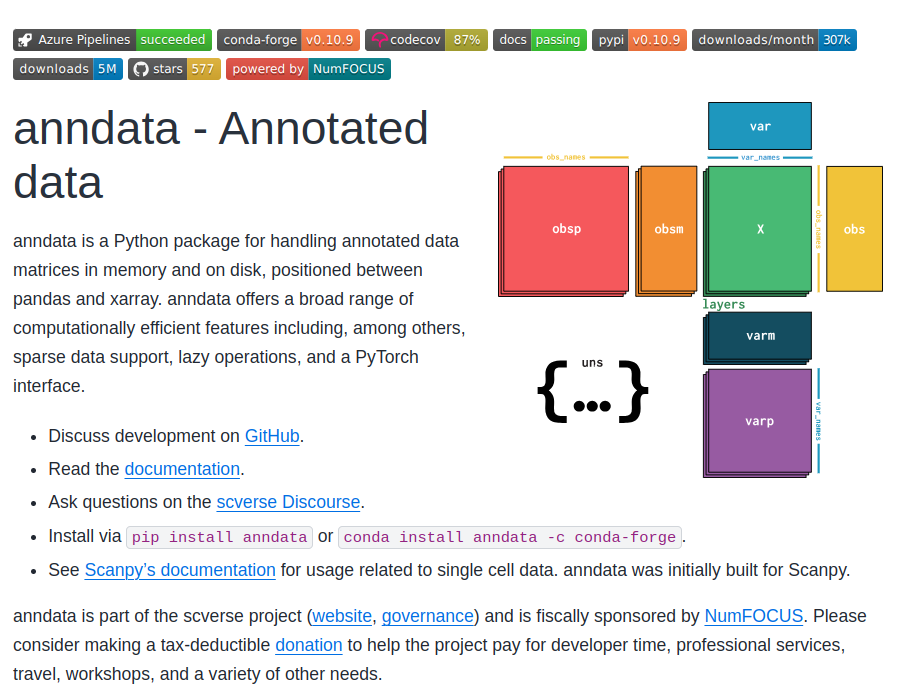

In [87]:
display(Image("figures/anndata.png"))

### Key Features of AnnData
- Structured Data Storage: AnnData provides a structured way to store both the main data matrix (e.g., gene expression counts) and the associated metadata, which includes information about cells, genes, experimental conditions, and other annotations.

- HDF5-Based Storage: It is built on top of the h5py and anndata libraries, allowing efficient memory management and disk storage. This is especially useful for large single-cell datasets, as data can be stored in HDF5 format to save memory.

Main Components:

- X: The main data matrix, typically holding the gene expression values. The rows usually represent cells, and the columns represent genes.
- obs: Stores metadata for the cells (rows of the data matrix), such as cell type labels, clustering information, or patient/sample information.
- var: Stores metadata for genes (columns of the data matrix), such as gene names, annotations, or gene-specific information.

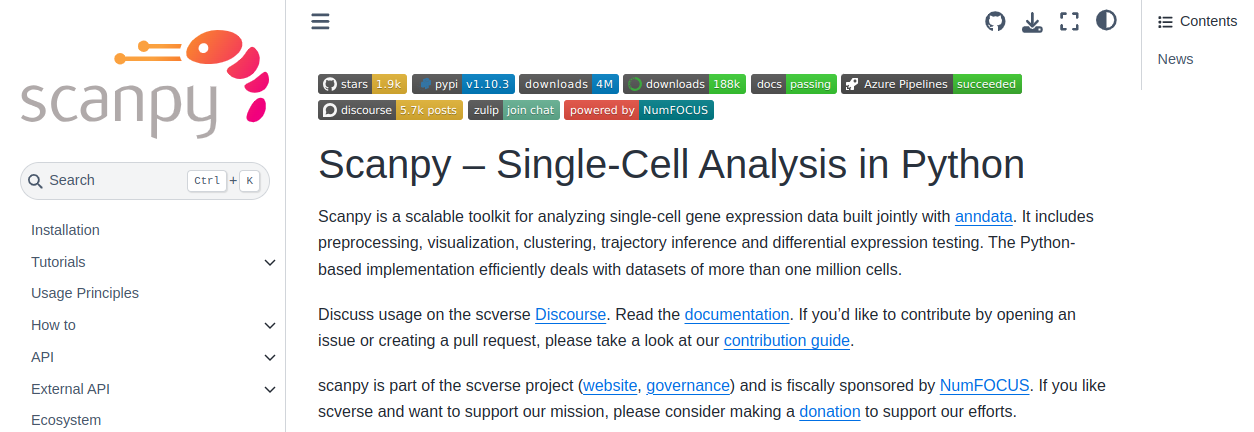

In [88]:
display(Image("figures/scanpy.png"))

## Data preprocessing

- Data normalisation
- Data imputation

### Data filtering and normalisation (ScanPy)

- Filter genes - keep genes that have at least `min_counts` counts  - `sc.pp.filter_genes()`
- Filter cells - filter cell outliers based on counts - `sc.pp.filter_cells()`         
- Single-cell RNA sequencing (scRNA-seq) data can vary greatly in sequencing depth across cells, leading to differences in total counts that are not biologically meaningful. Normalization scales the data so that each cell has the same total count to make data from different cells comparable.
- Normalize each cell by total counts over all genes, so every cell has the same total count after normalization. If a cell initially has a total expression count of 50,000 and target_sum=1e4, each gene's counts will be scaled down by a factor of 5 (i.e., 50000/10000 = 5). This ensures that all cells in the dataset have comparable total counts after normalization, facilitating downstream analysis such as clustering or differential expression testing - `scanpy.pp.normalize_total()`
- Highly variable genes - `sc.pp.highly_variable_genes()`

#### Data imputation using TruncatedSVD

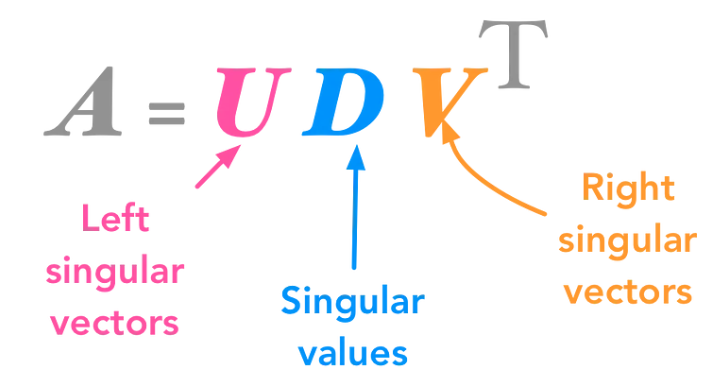

In [138]:
display(Image("figures/svd.png"))

- SVD - Singular value decomposition - factorisation of matrix A into a product of 3 matrices
- A is m x n matrix
- U is an m×m orthogonal matrix whose columns are the left singular vectors of A
- D is an m×n diagonal matrix whose diagonal elements are the singular values of A, arranged in descending order
- V.T is an n×n orthogonal matrix whose rows are the right singular vectors of A.
- Properties of SVD
  - Orthogonality: U and V are orthogonal matrices, meaning U.T x U = I or U x U.T = I and V.T x V = I or V x V.T = I
  - Singular Values: The diagonal elements of D are non-negative real numbers, called the singular values of A. They indicate the amount of variance captured by each singular vector.

- TruncatedSVD - Take first k columns of U, D(kxk, top k singular values) and first k rows of V.

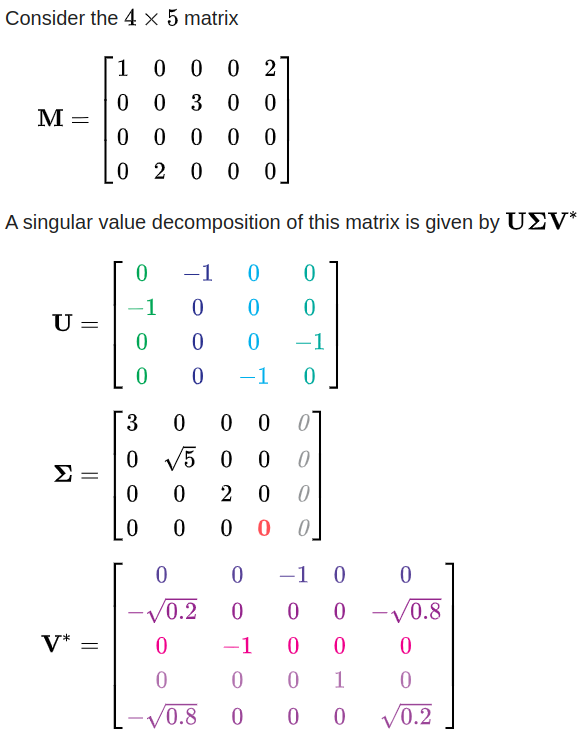

In [90]:
display(Image("figures/svdex1.png"))

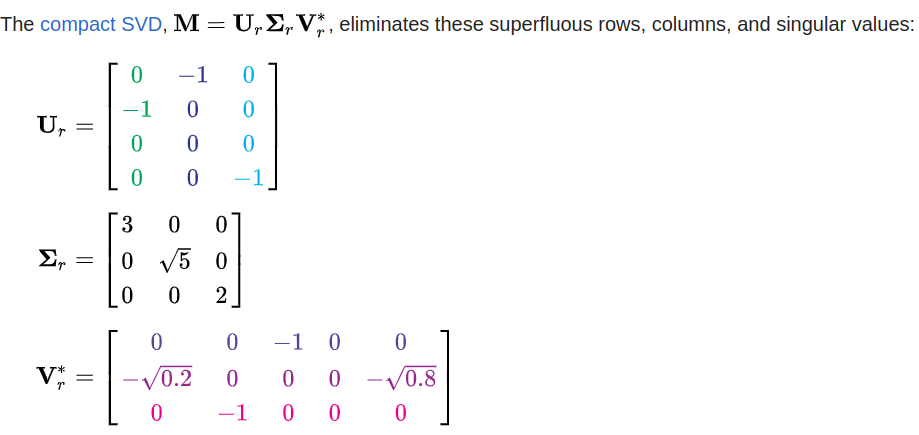

In [91]:
display(Image("figures/svdex2.png"))

### For Compact SVD
- Take first r (r is matrix's rank) columns of U, r x r from singular values, and first r rows from V.T or V*
### For Truncated SVD
- Take first k (r is matrix's rank) columns of U, k x k from singular values, and first k rows from V.T or V* where k << r

In [148]:
import os
import scanpy as sc
import h5py
import scipy as sp
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD

default_svd_params = {
    "n_components": 128,
    "random_state": 42,
    "n_oversamples": 20,
    "n_iter": 7,
}

encoder_x = LabelEncoder()
celltypes_keys = dict()

class IterativeSVDImputator(object):
    def __init__(self, svd_params=default_svd_params, iters=2):
        self.missing_values = 0.0
        self.svd_params = svd_params
        self.iters = iters
        self.svd_decomposers = [None for _ in range(self.iters)]

    def fit(self, X):
        mask = X == self.missing_values
        transformed_X = X.copy()
        for i in range(self.iters):
            self.svd_decomposers[i] = TruncatedSVD(**self.svd_params)
            self.svd_decomposers[i].fit(transformed_X)
            new_X = self.svd_decomposers[i].inverse_transform(
                self.svd_decomposers[i].transform(transformed_X))
            transformed_X[mask] = new_X[mask]

    def transform(self, X):
        mask = X == self.missing_values
        transformed_X = X.copy()
        for i in range(self.iters):
            new_X = self.svd_decomposers[i].inverse_transform(
                self.svd_decomposers[i].transform(transformed_X))
            transformed_X[mask] = new_X[mask]
        return transformed_X

In [149]:
def make_dir(directory_path, new_folder_name):
    """Creates an expected directory if it does not exist"""
    directory_path = os.path.join(directory_path, new_folder_name)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
    return directory_path

In [150]:
class scRNADataset(Dataset):
    def __init__(self, config, dataset_name, mode='train'):
        """Dataset class for scRNA data format.

        Args:
            config (dict): Dictionary containing options and arguments.
            dataset_name (str): Name of the dataset to load
            mode (bool): Defines whether the data is for Train or Test mode
        """

        self.config = config
        if mode == 'train':
            self.iterator = self.prepare_training_pairs
        else:
            self.iterator = self.prepare_test_pairs
        self.paths = config["paths"]
        self.dataset_name = dataset_name
        self.data_path = os.path.join(self.paths["data"], dataset_name)
        self.data, self.labels = self._load_data()
        self.data_dim = self.data.shape[1]

    def __len__(self):
        """Returns number of samples in the data"""
        return len(self.data)

    def prepare_training_pairs(self, idx):
        sample = self.data[idx]
        sample_tensor = torch.Tensor(sample)
        cluster = int(self.labels[idx])
        return sample, cluster

    def prepare_test_pairs(self, idx):
        sample = self.data[idx]
        cluster = int(self.labels[idx])
        return sample, cluster

    def __getitem__(self, index):
        """Returns batch"""
        return self.iterator(index)

    def _load_data(self):
        """Loads one of many available datasets, and returns features and labels"""

        data, labels = self.load_data(self.data_path)

        n_classes = len(list(set(labels.reshape(-1, ).tolist())))
        self.config["feat_dim"] = data.shape[1]
        if self.config["n_classes"] != n_classes:
            self.config["n_classes"] = n_classes
            print(f"{50 * '>'} Number of classes changed "
                  f"from {self.config['n_classes']} to {n_classes} {50 * '<'}")
        self.data_max = np.max(np.abs(data))
        self.data_min = np.min(np.abs(data))

        return data, labels

    def load_data(self, path):
        """Loads scRNA-seq dataset"""
        data_mat = h5py.File(
            f"{path}.h5", "r")
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        
        # encode labels
        if Y.dtype != "int64":
            Y = encoder_x.fit_transform(Y)
        celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
        print(celltypes_keys)

        # extract genes
        nb_genes = self.config["data_dim"]

        # convert to integers
        X = np.ceil(X).astype(np.int)
        
        count_X = X
        print(f"keeping {nb_genes} genes")

        # convert to AnnData format
        adata = sc.AnnData(X)
        print("Original data")
        print(X[:5], X.shape)
        print("====================================")
        print()
        # normalise
        adata = self.normalize(adata,
                               copy=True,
                               highly_genes=nb_genes,
                               size_factors=True,
                               normalize_input=True,
                               logtrans_input=True)

        # extract top nb_genes genes - highly variable genes
        sorted_genes = adata.var_names[np.argsort(adata.var["mean"])]
        adata = adata[:, sorted_genes]
        X = adata.X.astype(np.float32)
        # impute missing data
        imputator = IterativeSVDImputator(iters=1)
        imputator.fit(X)
        X = imputator.transform(X)
        print("After TruncatedSVD")
        print(X[:5], X.shape)
        print("====================================")
        print()
        return X, Y

    def normalize(self, adata, copy=True, highly_genes=None, filter_min_counts=True,
                  size_factors=True, normalize_input=True, logtrans_input=True):
        """
        Normalizes input data and retains only most variable genes
        (indicated by highly_genes parameter)

        Args:
            adata ([type]): [description]
            copy (bool, optional): [description]. Defaults to True.
            highly_genes ([type], optional): [description]. Defaults to None.
            filter_min_counts (bool, optional): [description]. Defaults to True.
            size_factors (bool, optional): [description]. Defaults to True.
            normalize_input (bool, optional): [description]. Defaults to True.
            logtrans_input (bool, optional): [description]. Defaults to True.

        Raises:
            NotImplementedError: [description]

        Returns:
            [type]: [description]
        """
        if isinstance(adata, sc.AnnData):
            if copy:
                adata = adata.copy()
        elif isinstance(adata, str):
            adata = sc.read(adata)
        else:
            raise NotImplementedError
        norm_error = 'Make sure that the dataset (adata.X) contains unnormalized count data.'
        assert 'n_count' not in adata.obs, norm_error
        if adata.X.size < 50e6:  # check if adata.X is integer only if array is small
            if sp.sparse.issparse(adata.X):
                assert (adata.X.astype(int) != adata.X).nnz == 0, norm_error
            else:
                assert np.all(adata.X.astype(int) == adata.X), norm_error

        if filter_min_counts:
            sc.pp.filter_genes(adata, min_counts=1)
            sc.pp.filter_cells(adata, min_counts=1)
        print("After filtering")
        print()
        print(adata.X[:5], adata.X.shape)
        print("====================================")
        print()
        if size_factors or normalize_input or logtrans_input:
            adata.raw = adata.copy()
        else:
            adata.raw = adata
        if size_factors:
            sc.pp.normalize_total(adata, target_sum=1e4)
            print("After normalize_total")
            print()
            print(adata.X[:5], adata.X.shape)
            print("Sum of first row: {}".format(adata.X[0, :].sum()))
            print("Sum of second row: {}".format(adata.X[1, :].sum()))
            print("====================================")
            print()
            adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
        else:
            adata.obs['size_factors'] = 1.0
        if logtrans_input:
            sc.pp.log1p(adata)
            print("After log1p transformation")
            print()
            print(adata.X[:5], adata.X.shape)
            print("====================================")
            print()
        if highly_genes != None:
            sc.pp.highly_variable_genes(
                adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=highly_genes, subset=True)
            print("After getting highly_variable_genes")
            print()
            print(adata.X, adata.X.shape)
            print("====================================")
            print()
        if normalize_input:
            sc.pp.scale(adata)
            print("After scaling")
            print()
            print(adata.X[:5], adata.X.shape)
            print("Mean and variance of first column: {}, {}".format(adata.X[:, 0].mean(), adata.X[:, 0].var()))
            print("Mean and variance of second column: {}, {}".format(adata.X[:, 1].mean(), adata.X[:, 1].var()))
            print("====================================")
            print()
        return adata

In [151]:
class Loader(object):
    """ Data loader """

    def __init__(self, config, dataset_name, drop_last=True, kwargs={}):
        """Pytorch data loader

        Args:
            config (dict): Dictionary containing options and arguments.
            dataset_name (str): Name of the dataset to load
            drop_last (bool): True in training mode, False in evaluation.
            kwargs (dict): Dictionary for additional parameters if needed

        """
        # Get batch size
        batch_size = config["batch_size"]
        # Get config
        self.config = config
        # Get the datasets
        print("Loading train and test datasets")
        train_dataset, test_dataset = self.get_dataset(
            dataset_name)
        self.data_max = train_dataset.data_max
        self.data_min = train_dataset.data_min

        # Set the loader for training set
        self.train_loader = DataLoader(
            train_dataset, batch_size=batch_size, shuffle=True, drop_last=drop_last, **kwargs)
        # Set the loader for test set
        self.test_loader = DataLoader(
            test_dataset, batch_size=batch_size*5, shuffle=False, drop_last=False, **kwargs)

    def get_dataset(self, dataset_name):
        """Returns training, validation, and test datasets"""
        # Create dictionary for loading functions of datasets.
        # If you add a new dataset, add its corresponding dataset class here in the form 'dataset_name': ClassName
        loader_map = {'default_loader': scRNADataset}
        # Get dataset. Check if the dataset has a custom class.
        # If not, then assume a tabular data with labels in the first column
        dataset = loader_map[dataset_name] if dataset_name in loader_map.keys(
        ) else loader_map['default_loader']
        # Training  datasets
        train_dataset = dataset(
            self.config, dataset_name=dataset_name, mode='train')
        # Test dataset
        test_dataset = dataset(
            self.config, dataset_name=dataset_name, mode='test')
        # Return
        return train_dataset, test_dataset

def apply_noise(X, p=[0.2,0.4]):
    p = torch.tensor(p)
    should_swap = torch.bernoulli(p.to(
        X.device) * torch.ones((X.shape)).to(X.device))
    corrupted_X = torch.where(
        should_swap == 1, X[torch.randperm(X.shape[0])], X)
    masked = (corrupted_X != X).float()
    return corrupted_X, masked

In [152]:
args = {}
args["num_workers"] = 4
args["paths"] = {"data": "data/",
                "results": "./res/"}
args['batch_size'] = 256
args["data_dim"] = 1000
args['n_classes'] = 9 #4
args['epochs'] = 80 #80
args["dataset"] = "Smart-seq2"
args["learning_rate"] = 1e-3
args["latent_dim"] = 32 #128
path = args["paths"]["data"]
files = ["Melanoma_5K"]

'''files = ["Pollen", "Quake_Smart-seq2_Lung", "Limb_Muscle", 
         "worm_neuron_cell", "Melanoma_5K", "Young", "Guo", "Baron", 
         "Wang", "Quake_10x_Spleen", "Shekhar", "Macosko", 
         "Tosches", "Bach", "hrvatin"]'''

results = pd.DataFrame()
dataset = files[0]
save_dir = make_dir(args["paths"]["results"], "a_summary")
print(f">> {dataset}")
args["dataset"] = files[0]
args["save_path"] = make_dir("data/sc_data/scMAE/" + str(123), dataset)

data_load = Loader(args, dataset_name=args["dataset"], drop_last=True)

>> Melanoma_5K
Loading train and test datasets
{0: 'B cell', 1: 'CAF', 2: 'CD4+ T cell', 3: 'CD8+ T cell', 4: 'Endothelial cell', 5: 'Macrophage', 6: 'NK cell', 7: 'Tumor', 8: 'Unknown'}
keeping 1000 genes
Original data
[[  0 594   0 ...   0   5   0]
 [  0 330   0 ...   0 126   0]
 [  0 635   3 ...  13   2   0]
 [  0 235   0 ...  12  27   0]
 [  0 320   0 ...   2  21   0]] (4513, 23684)

After filtering

[[  0 594   0 ...   0   5   0]
 [  0 330   0 ...   0 126   0]
 [  0 635   3 ...  13   2   0]
 [  0 235   0 ...  12  27   0]
 [  0 320   0 ...   2  21   0]] (4513, 22793)

After normalize_total

[[ 0.         60.31314     0.         ...  0.          0.5076864
   0.        ]
 [ 0.         33.555       0.         ...  0.         12.811909
   0.        ]
 [ 0.         64.94104     0.30680808 ...  1.3295016   0.20453872
   0.        ]
 [ 0.         24.2453      0.         ...  1.2380579   2.7856302
   0.        ]
 [ 0.         32.972694    0.         ...  0.20607933  2.1638331
   0.        

## Kmeans

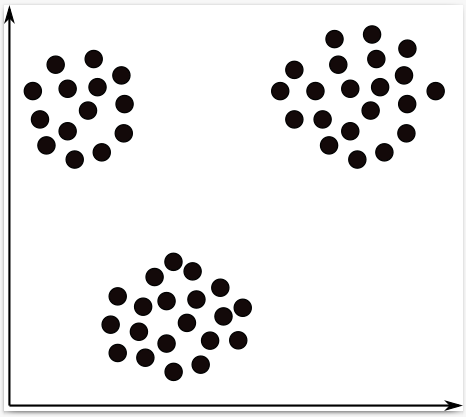

In [97]:
display(Image("figures/kmeans1.png"))

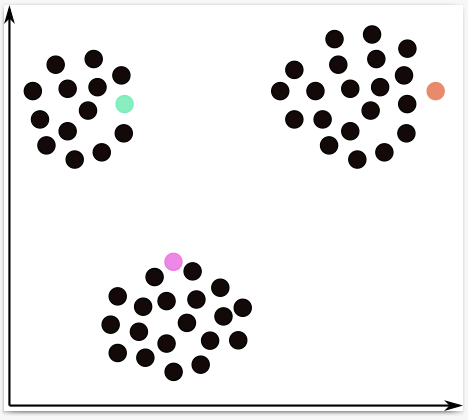

In [98]:
display(Image("figures/kmeans2.png"))

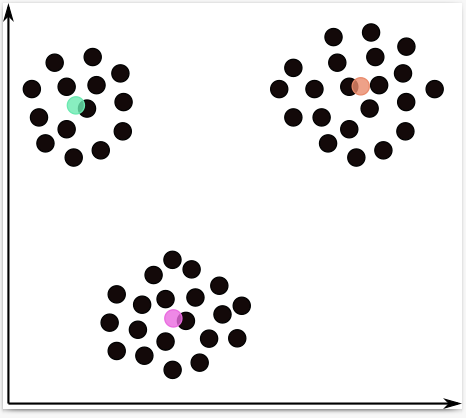

In [99]:
display(Image("figures/kmeans3.png"))

## Autoencoder

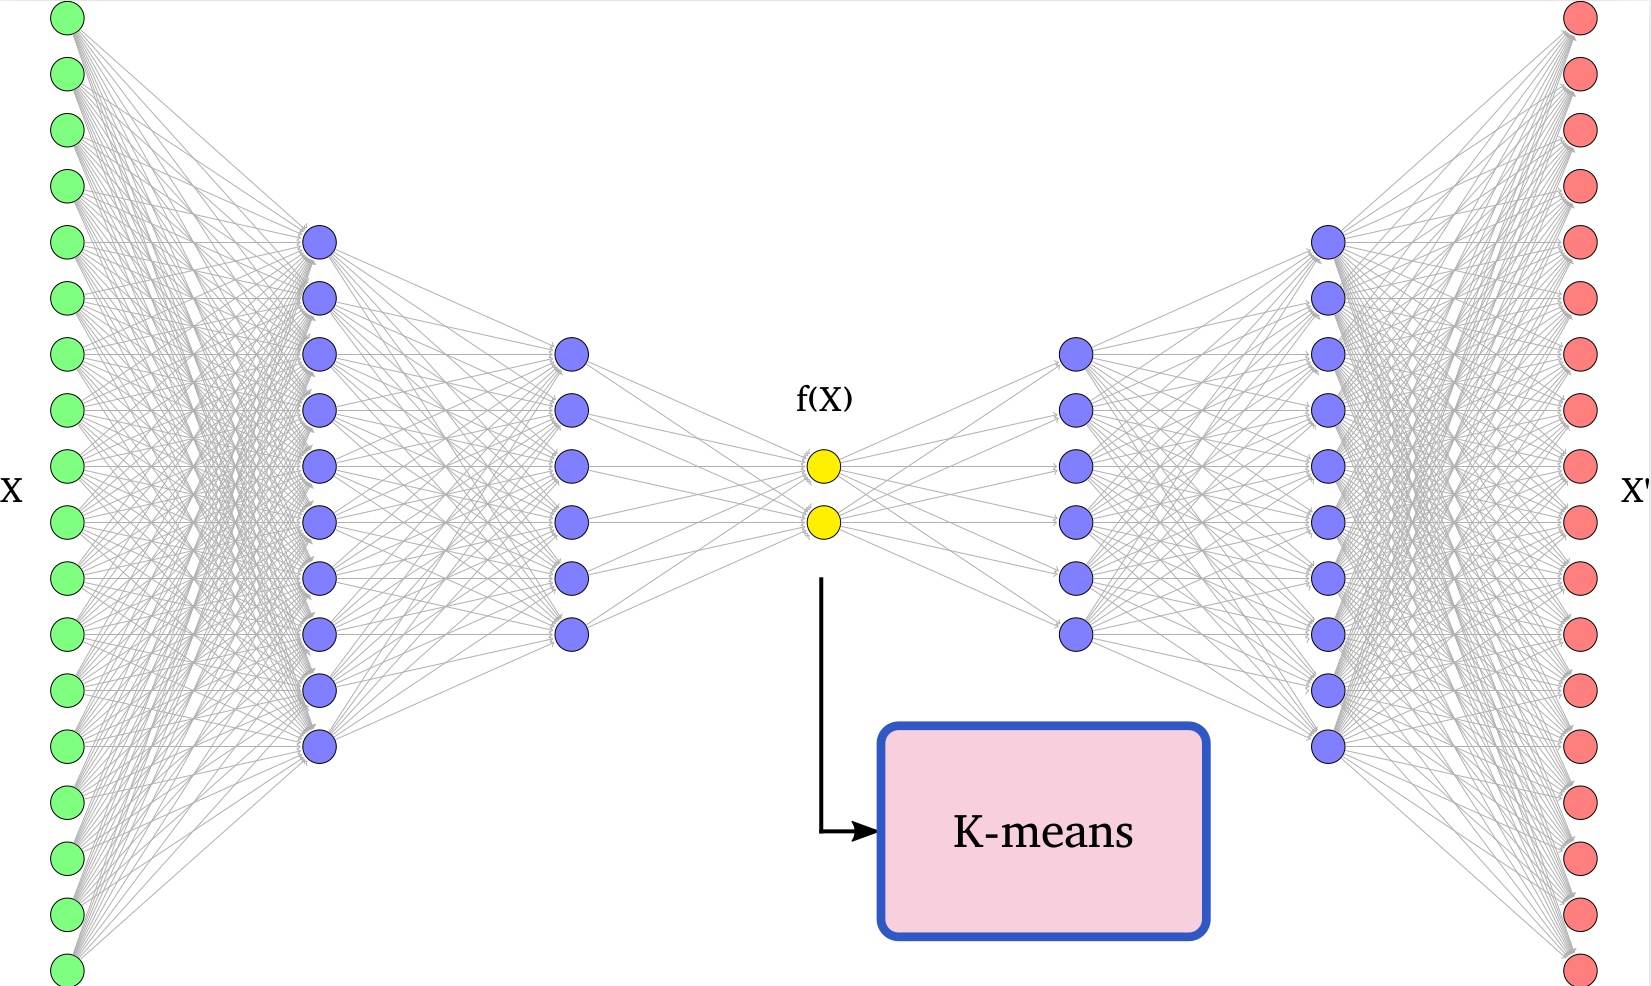

In [100]:
display(Image("figures/autoencoder_kmeans.png"))

### Single-cell Masked Autoencoder (scMAE) workflow

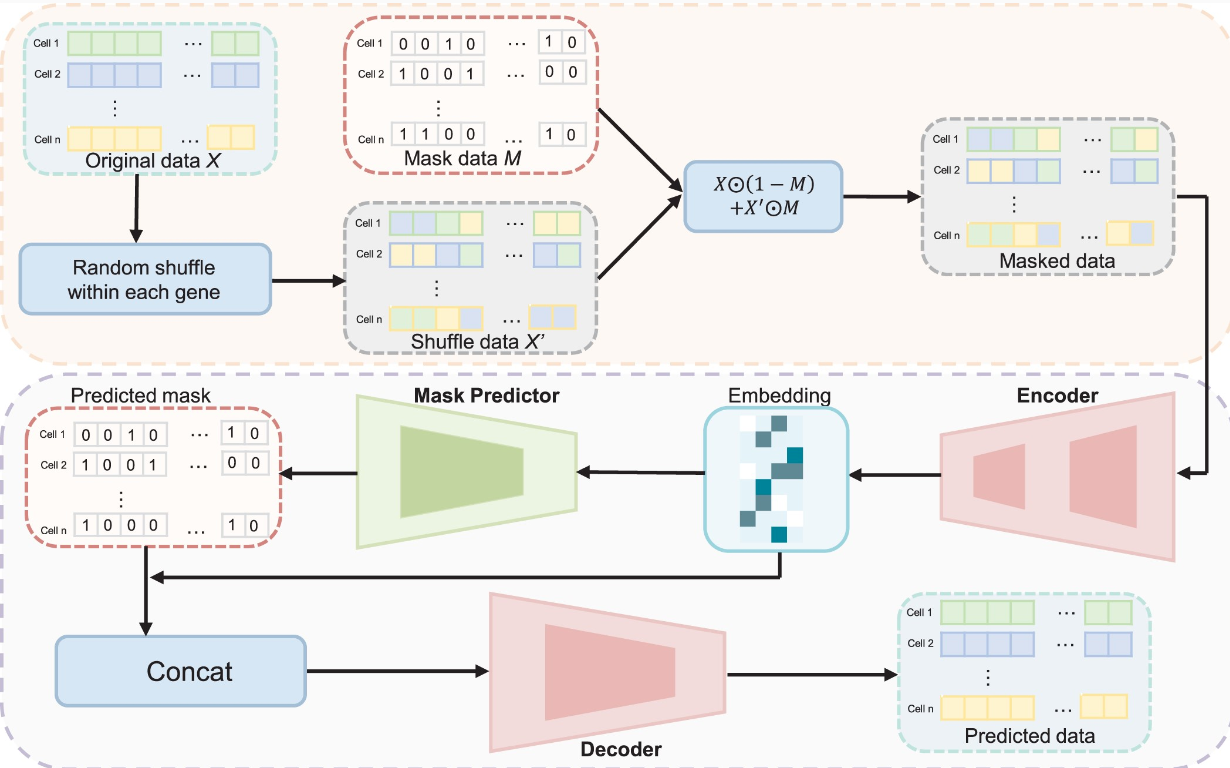

In [101]:
display(Image("figures/scMAE_workflow.png"))

## Mask generation

In [102]:
def apply_noise_show(X, p=[0.2, 0.4]):
    p = torch.tensor(p)
    print("Applying noise ...")
    print(p[:20], p.shape)
    print()
    # Draws binary random numbers (0 or 1) from a Bernoulli distribution.
    should_swap = torch.bernoulli(p.to(
        X.device) * torch.ones((X.shape)).to(X.device))
    print("Masking probabilities")
    print(should_swap, should_swap.shape)
    print()
    print("How many ones (how many to be swapped) for the first cell")
    print((should_swap[0, :] == 1).sum())
    print()
    corrupted_X = torch.where(
        should_swap == 1, X[torch.randperm(X.shape[0])], X)
    print("Original data")
    print(X, X.shape)
    print()
    print("Corrupted data")
    print(corrupted_X, corrupted_X.shape)
    print()
    masked = (corrupted_X != X).float()
    print("Final mask")
    print(masked, masked.shape)
    print()
    print("How many ones for the first cell: # Changed, # unchanged")
    print((masked[0, :] == 1).sum(), (masked[0, :] == 0).sum())
    print()
    return corrupted_X, masked

data_loader_test_show = data_load.train_loader
mask_probas = [0.4]*1000
for step, (x, y) in enumerate(data_loader_test_show):
    apply_noise_show(x, mask_probas)
    break

Applying noise ...
tensor([0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000,
        0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000, 0.4000,
        0.4000, 0.4000]) torch.Size([1000])

Masking probabilities
tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 1., 0.],
        [1., 1., 1.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 0., 1., 0.]]) torch.Size([256, 1000])

How many ones (how many to be swapped) for the first cell
tensor(378)

Original data
tensor([[-0.0149, -0.0149, -0.0149,  ...,  1.5127,  0.9686,  0.9574],
        [-0.0149, -0.0149, -0.0149,  ...,  0.0210, -1.0769,  0.5704],
        [-0.0149, -0.0149, -0.0149,  ..., -1.2205, -1.2656, -0.6162],
        ...,
        [-0.0149, -0.0149, -0.0149,  ..., -0.9413, -0.8750,  0.7350],
        [-0.0149, -0.0149, -0.0149,  ...,  0.4118, -0.5037, -2.4856],
        [-0.0149, -0.0149, 

In [103]:
# Example of torch.bernoulli()
# https://pytorch.org/docs/stable/generated/torch.bernoulli.html
a = torch.empty(3, 3).uniform_(0, 1)
a

tensor([[0.9185, 0.9829, 0.6322],
        [0.6967, 0.4182, 0.0394],
        [0.4328, 0.4061, 0.1440]])

In [104]:
torch.bernoulli(a)

tensor([[1., 1., 1.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [105]:
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits as bce_logits
from torch.nn.functional import mse_loss as mse


class AutoEncoder(torch.nn.Module):
    def __init__(
        self,
        num_genes,
        hidden_size=128,
        dropout=0,
        masked_data_weight=.75,
        mask_loss_weight=0.7,
    ):
        super().__init__()
        self.num_genes = num_genes
        self.masked_data_weight = masked_data_weight
        self.mask_loss_weight = mask_loss_weight

        self.encoder = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.num_genes, 256),
            nn.LayerNorm(256),
            # Mish: A self-regularized non-monotonic neural activation function
            nn.Mish(inplace=True),
            nn.Linear(256, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.Mish(inplace=True),
            nn.Linear(hidden_size, hidden_size)
        )

        self.mask_predictor = nn.Linear(hidden_size, num_genes)
        self.decoder = nn.Linear(
            in_features=hidden_size+num_genes, out_features=num_genes)

    def forward_mask(self, x):
        # latent representation
        latent = self.encoder(x)
        # predict mask
        predicted_mask = self.mask_predictor(latent)
        # reconstruct original data / decode original data using 
        # latent representation
        reconstruction = self.decoder(
            torch.cat([latent, predicted_mask], dim=1))

        return latent, predicted_mask, reconstruction

    def loss_mask(self, x, y, mask):
        latent, predicted_mask, reconstruction = self.forward_mask(x)
        # masked_data_weight=0.75
        w_nums = mask * self.masked_data_weight + (1 - mask) * (1 - self.masked_data_weight)

        # loss for reconstructing original data
        # mask_loss_weight=0.7
        reconstruction_loss = (1-self.mask_loss_weight) * torch.mul(
            w_nums, mse(reconstruction, y, reduction='none'))

        # loss for predicting masks
        # mask_loss_weight=0.7
        mask_loss = self.mask_loss_weight * \
            bce_logits(predicted_mask, mask, reduction="mean")
        
        reconstruction_loss = reconstruction_loss.mean()

        # overall loss
        loss = reconstruction_loss + mask_loss 
        return latent, loss

    def feature(self, x):
        latent = self.encoder(x)
        return latent

In [106]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [107]:
from __future__ import print_function
import time
import torch
import numpy as np
from sklearn import metrics


def evaluate(label, pred):
    nmi = metrics.normalized_mutual_info_score(label, pred)
    ari = metrics.adjusted_rand_score(label, pred)
    return nmi, ari

### Evaluation metrics
- **NMI**: Normalized Mutual Information (NMI) is a normalization of the Mutual Information (MI) score to scale the results between 0 (no mutual information) and 1 (perfect correlation).
- **ARI**: Adjusted Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings. The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical
- **Silhouette Coefficient** is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar

In [154]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import random
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix


def inference(net, data_loader_test):
    net.eval()
    original_data = []
    feature_vector = []
    labels_vector = []
    with torch.no_grad():
        for step, (x, y) in enumerate(data_loader_test):
            feature_vector.extend(net.feature(x.cuda()).detach().cpu().numpy())
            labels_vector.extend(y.numpy())
            original_data.extend(x.detach().cpu().numpy())
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    original_data = np.array(original_data)
    return feature_vector, labels_vector, original_data


def plot_umap(pre_data, true_labels, pred_labels, cmap):

    n_neighbors=50
    min_dist=0.99
    metric='correlation'
    unique_labels = np.unique(true_labels)
    print("Number of cell types: {}".format(unique_labels))
    print("Data dimensions: {}".format(pre_data.shape))
    celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
    print(celltypes_keys)
    print(cmap)

    embeddings = umap.UMAP(
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric='correlation'
    ).fit_transform(pre_data)

    # Create a DataFrame with UMAP components and true labels
    #data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": true_labels}
    #df_pre_sc = pd.DataFrame(data)
    #df_pre_sc['Cluster'] = true_labels
    #df_pre_sc['Cell types'] = df_pre_sc['Cluster'].map(celltypes_keys)
    #print("true_labels", true_labels[:5], df_pre_sc['Cell types'][:5])
    #print(df_pre_sc.head())
    #print()
    #################
    # Create a DataFrame with UMAP components and pred labels
    data_pred = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": true_labels}
    df_pre_sc_pred = pd.DataFrame(data_pred)

    #df_pre_sc_pred['Cluster'] = pred_labels
    df_pre_sc_pred['Celltypes'] = df_pre_sc_pred['Label'].map(celltypes_keys)
    print(df_pre_sc_pred.head())

    plt.figure(figsize=(8, 6))
    
    #sns.scatterplot(x="UMAP1", y="UMAP2", hue="Celltypes", palette='tab10', data=df_pre_sc_pred, s=5)
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Celltypes", palette=cmap, data=df_pre_sc_pred, s=10)
    plt.title("UMAP Visualization data with original dimensions and true labels")
    plt.show()


def plot_true_pred_umap(pre_data, true_labels, pred_labels, cmap):

    n_neighbors=50
    min_dist=0.99
    metric='correlation'
    unique_labels = np.unique(true_labels)
    print("Number of cell types: {}".format(unique_labels))
    print("Data dimensions: {}".format(pre_data.shape))
    celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
    print(celltypes_keys)
    print(cmap)
    embeddings = umap.UMAP(
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        metric='correlation'
    ).fit_transform(pre_data)

    # Create a DataFrame with UMAP components and true labels
    #data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": true_labels}
    #df_pre_sc = pd.DataFrame(data)

    #df_pre_sc['Celltypes'] = df_pre_sc['Label'].map(celltypes_keys)
    #print(df_pre_sc.head())

    #plt.figure(figsize=(8, 6))
    #sns.scatterplot(x="UMAP1", y="UMAP2", hue="Celltypes", palette='tab10', data=df_pre_sc, s=5)
    #plt.title("UMAP Visualization latent dimensions data and true labels")
    #plt.show()

    #################
    # Create a DataFrame with UMAP components and pred labels
    data_pred = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": pred_labels}
    df_pre_sc_pred = pd.DataFrame(data_pred)

    df_pre_sc_pred['Celltypes'] = df_pre_sc_pred['Label'].map(celltypes_keys)
    print(df_pre_sc_pred.head())

    plt.figure(figsize=(8, 6))
    
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Celltypes", palette=cmap, data=df_pre_sc_pred, s=10)
    plt.title("UMAP Visualization latent dimensions data and pred labels")
    plt.show()


def train(args):
    data_load = Loader(args, dataset_name=args["dataset"], drop_last=True)
    data_loader = data_load.train_loader
    data_loader_test = data_load.test_loader
    x_shape = args["data_dim"]

    results = []

    # Hyper-params
    init_lr = args["learning_rate"]
    max_epochs = args["epochs"]
    mask_probas = [0.4]*x_shape

    # setup model
    model = AutoEncoder(
        num_genes=x_shape,
        hidden_size=args["latent_dim"],
        masked_data_weight=0.75,
        mask_loss_weight=0.7
    ).cuda()
    model_checkpoint = 'model_checkpoint.pth'

    optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

    # train model
    print("Training autoencoder")
    for epoch in range(max_epochs):
        model.train()
        meter = AverageMeter()
        for i, (x, y) in enumerate(data_loader):
            x = x.cuda()
            x_corrputed, mask = apply_noise(x, mask_probas)
            optimizer.zero_grad()
            x_corrputed_latent, loss_ae = model.loss_mask(x_corrputed, x, mask)
            loss_ae.backward()
            optimizer.step()
            meter.update(loss_ae.detach().cpu().numpy())

        if ((epoch + 1) % 80) == 0:
            print("Evaluating at epoch: {}".format(epoch + 1))
            # Generator in eval mode
            latent, true_label, orig_x = inference(model, data_loader_test)
            
            if latent.shape[0] < 10000:
                print("Clustering cells")
                clustering_model = KMeans(n_clusters=args["n_classes"])
                clustering_model.fit(latent)
                pred_label = clustering_model.labels_

            # same cluster color for different plots
            celltypes_keys = {index: label.decode('utf-8') for index, label in enumerate(encoder_x.classes_)}
            celltypes = list(celltypes_keys.values())
            palette = dict()
            color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22']
            for i, item in enumerate(color_list):
                palette[celltypes[i]] = color_list[i]
            
            plot_umap(orig_x, true_label, pred_label, palette)
            plot_true_pred_umap(latent, true_label, pred_label, palette)

            nmi, ari = evaluate(true_label, pred_label)
            ss = silhouette_score(latent, pred_label)

            res = {}
            res["nmi"] = nmi
            res["ari"] = ari
            res["sil"] = ss
            res["dataset"] = args["dataset"]
            res["epoch"] = epoch
            results.append(res)

            print("\tEvalute: [nmi: %f] [ari: %f]" % (nmi, ari))

            np.save(args["save_path"]+"/embedding_"+str(epoch)+".npy", 
                    latent)
            pd.DataFrame({"True": true_label, 
                        "Pred": pred_label}).to_csv(args["save_path"]+"/types_"+str(epoch)+".txt")

    torch.save({
        "optimizer": optimizer.state_dict(),
        "model": model.state_dict()
    }, model_checkpoint
    )

    return results

In [155]:
def run_scMAE():
    for i in range(1):
        seed = random.randint(1, 100)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)

        args = {}
        args["num_workers"] = 4
        args["paths"] = {"data": "data/",
                        "results": "./res/"}
        args['batch_size'] = 256
        args["data_dim"] = 1000
        args['n_classes'] = 9
        args['epochs'] = 80
        args["dataset"] = "Smart-seq2"
        args["learning_rate"] = 1e-3
        args["latent_dim"] = 128

        print(args)

        path = args["paths"]["data"]
        files = ["Melanoma_5K"]

        ## All compared dataset names.
        ## You can find the corresponding H5 files of gene expression in the Zenodo link
        '''files = ["Pollen", "Quake_Smart-seq2_Lung", "Limb_Muscle", 
                 "worm_neuron_cell", "Melanoma_5K", "Young", "Guo", "Baron", 
                 "Wang", "Quake_10x_Spleen", "Shekhar", "Macosko", 
                 "Tosches", "Bach", "hrvatin"]'''

        results = pd.DataFrame()
        save_dir = make_dir(args["paths"]["results"], "a_summary")
        for dataset in files:
            print(f">> {dataset}")
            args["dataset"] = dataset
            args["save_path"] = make_dir("data/sc_data/scMAE/" + str(i), dataset)

            res = train(args)
            print(res)
            results = results.append(res)
            results.to_csv(args["paths"]["results"] +
                        "/res_all_data_test"+str(i)+".csv", header=True)

{'num_workers': 4, 'paths': {'data': 'data/', 'results': './res/'}, 'batch_size': 256, 'data_dim': 1000, 'n_classes': 9, 'epochs': 80, 'dataset': 'Smart-seq2', 'learning_rate': 0.001, 'latent_dim': 128}
>> Melanoma_5K
Loading train and test datasets
{0: 'B cell', 1: 'CAF', 2: 'CD4+ T cell', 3: 'CD8+ T cell', 4: 'Endothelial cell', 5: 'Macrophage', 6: 'NK cell', 7: 'Tumor', 8: 'Unknown'}
keeping 1000 genes
Original data
[[  0 594   0 ...   0   5   0]
 [  0 330   0 ...   0 126   0]
 [  0 635   3 ...  13   2   0]
 [  0 235   0 ...  12  27   0]
 [  0 320   0 ...   2  21   0]] (4513, 23684)

After filtering

[[  0 594   0 ...   0   5   0]
 [  0 330   0 ...   0 126   0]
 [  0 635   3 ...  13   2   0]
 [  0 235   0 ...  12  27   0]
 [  0 320   0 ...   2  21   0]] (4513, 22793)

After normalize_total

[[ 0.         60.31314     0.         ...  0.          0.5076864
   0.        ]
 [ 0.         33.555       0.         ...  0.         12.811909
   0.        ]
 [ 0.         64.94104     0.3068080

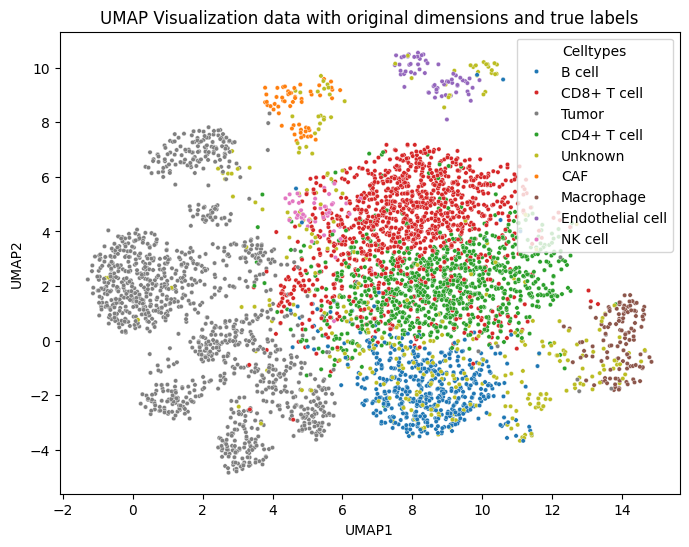

Number of cell types: [0 1 2 3 4 5 6 7 8]
Data dimensions: (4513, 128)
{0: 'B cell', 1: 'CAF', 2: 'CD4+ T cell', 3: 'CD8+ T cell', 4: 'Endothelial cell', 5: 'Macrophage', 6: 'NK cell', 7: 'Tumor', 8: 'Unknown'}
{'B cell': '#1f77b4', 'CAF': '#ff7f0e', 'CD4+ T cell': '#2ca02c', 'CD8+ T cell': '#d62728', 'Endothelial cell': '#9467bd', 'Macrophage': '#8c564b', 'NK cell': '#e377c2', 'Tumor': '#7f7f7f', 'Unknown': '#bcbd22'}
      UMAP1      UMAP2  Label    Celltypes
0 -2.571712 -16.032829      1          CAF
1 -3.839587  -2.722965      2  CD4+ T cell
2 -5.559931   6.022399      3  CD8+ T cell
3  6.237854  13.628323      7        Tumor
4 -1.970152   8.793954      3  CD8+ T cell


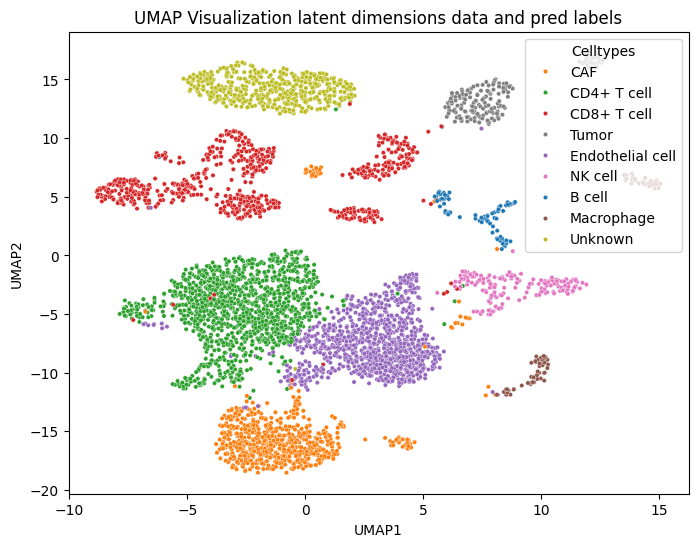

	Evalute: [nmi: 0.732112] [ari: 0.661626]
[{'nmi': 0.7321119546774345, 'ari': 0.6616263725930707, 'sil': 0.33958745, 'dataset': 'Melanoma_5K', 'epoch': 79}]


In [156]:
run_scMAE()